<a href="https://colab.research.google.com/github/UN-GCPDS/python-gcpds.localbiplot/blob/main/docs/source/notebooks/01-module%20example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datashader bokeh holoviews   --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 21.1 MB/s eta 0:00:00


# **Installing Our Local Biplot Library**

In [2]:
!pip install -U git+https://github.com/UN-GCPDS/python-gcpds.localbiplot.git --quiet

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 1.5 MB/s eta 0:00:00



## Import Necessary Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import matplotlib as mpl
from sklearn.preprocessing import StandardScaler, MinMaxScaler

 ### Loading Local Biplot Library to Our Notebook

In [4]:
import gcpds.localbiplot as lb


# **Uniform Manifold Approximation and Projection (UMAP) Fundamentals**

![gifumap](https://umap-learn.readthedocs.io/en/latest/_images/aligned_umap_pendigits_anim.gif)

- UMAP is a dimensionality reduction technique that models high-dimensional space as a fuzzy topological structure and optimizes it in low-dimensional space, preserving both global and local distances.

- UMAP constructs a weighted graph to represent the fuzzy topological structure.

- The probability $p_{nn'}$  representing the weight of the edge between $\mathbf{x}_n$ and $\mathbf{x}_{n'}$ is given by:

\begin{equation}
p_{nn'} = \exp\left(-\frac{\|\mathbf{x}_n - \mathbf{x}_{n'}\| - \rho_n}{\sigma_n}\right),
\end{equation}

- $\rho_n$  is the distance to the nearest neighbor of $\mathbf{x}_n$, ensuring that local distances are not affected by noise.

- $\sigma_n$ is determined by a fixed number of neighbors.

- The fuzzy relationship becomes symmetric as:

\begin{equation}
\tilde{p}_{nn'} = p_{nn'} + p_{n'n} - p_{nn'} p_{n'n}.
\end{equation}



- The relationships in the low-dimensional space are fixed using a heavy-tailed t-distribution:

\begin{equation}
q_{nn'} = \left(1 + a \|\mathbf{z}_n - \mathbf{z}_{n'}\|^{2b}\right)^{-1},
\end{equation}

With $a$ and $b$ as the parameters of the distribution. These are generally set to 1.

- UMAP minimizes the cross-entropy:

\begin{equation}
C(P;Q) = \sum_{n \neq n'} \left( -\tilde{p}_{nn'} \log(q_{nn'}) - (1 - \tilde{p}_{nn'}) \log(1 - q_{nn'}) \right).
\end{equation}

- Conventionally, gradient-based methods are used to solve the optimization.

## Swiss Roll Example

In [5]:
import umap
import umap.plot
from sklearn.datasets import make_swiss_roll
#se ilustra nuevamente sobre swiss roll
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

## Initializing a UMAP Model.


> Agregar bloque entrecomillado


- `red = umap.UMAP(n_components=2, n_neighbors=40, min_dist=0.2)`:
  - **Parameters:**
      - `n_components=2`: Reduces the data to 2 dimensions.
      - `n_neighbors=40`: Defines the number of neighboring points used for the manifold learning process. A larger number makes the embedding more global, capturing broader structures in the data.
      - `min_dist=0.2`: Controls how tightly UMAP clusters points. Smaller values force points to be closer together, while larger values allow more space between clusters.


  - `X_reduced_umap = red.fit_transform(X)`:
      - Fits the UMAP model to the data `X` and transforms it, reducing its dimensionality to the specified 2 components.
      - The result, `X_reduced_umap`, is a 2D representation of the original high-dimensional data, which can now be visualized in a scatter plot.


In [6]:
red = umap.UMAP(n_components=2,n_neighbors=40, min_dist=0.2)
X_reduced_umap = red.fit_transform(X)


## Scatter Plot of the UMAP-reduced Data.

- `X_reduced_umap[:, 0]` and `X_reduced_umap[:, 1] ` represent the two-dimensional UMAP components.'c=t' assigns colors to the points based on the target variable 't'.


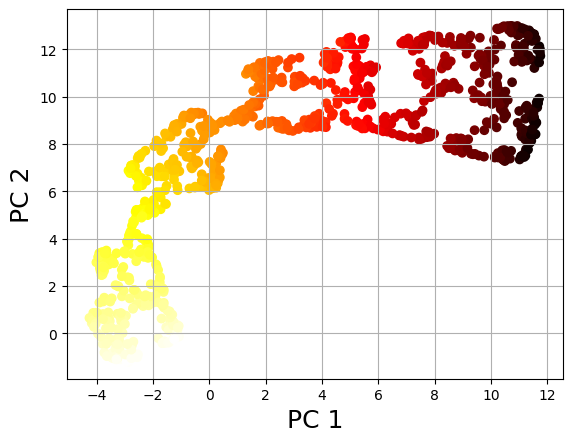

In [7]:
plt.scatter(X_reduced_umap[:, 0], X_reduced_umap[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel('PC 1', fontsize=18)
plt.ylabel('PC 2', fontsize=18)
plt.grid(True)
plt.show()



- UMAP offers a series of methods for [interactive plots](https://umap-learn.readthedocs.io/en/latest/plotting.html).

<Axes: >

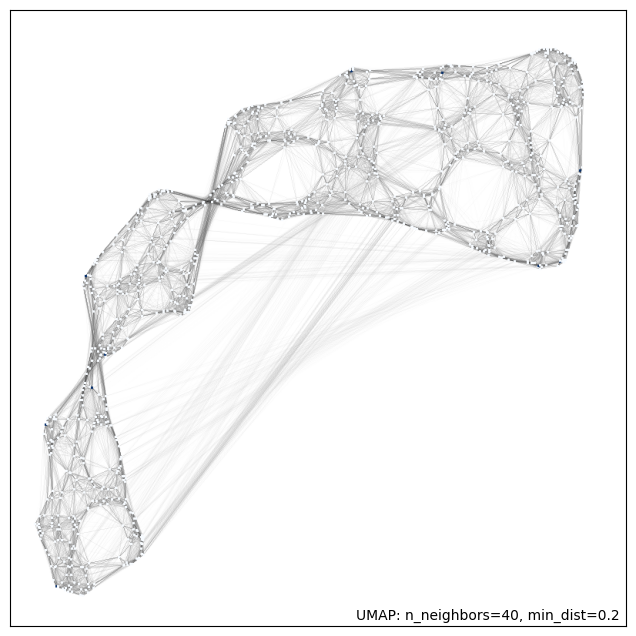

In [8]:
umap.plot.connectivity(red, show_points=True)

<Axes: >

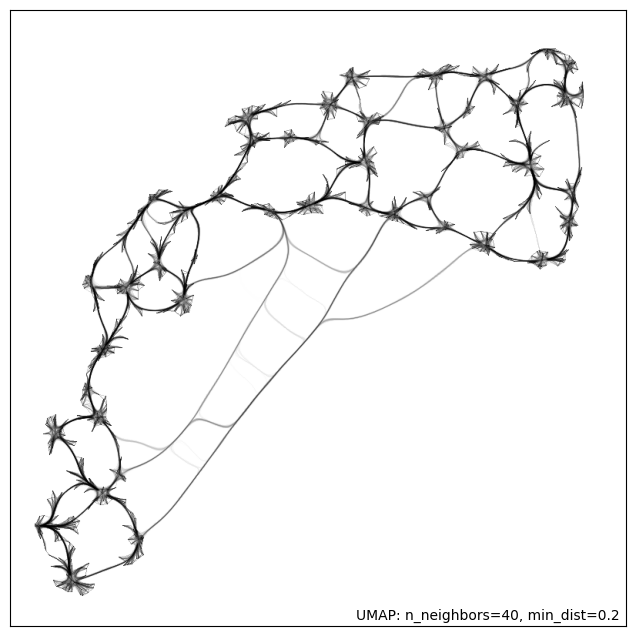

In [9]:
umap.plot.connectivity(red, edge_bundling='hammer')

# **Local Biplot Examples**

## **Multivariate Gaussians**

We create a  data matrix $\mathbf{X} \in ℝ^{N \times P}$  by creating three clouds of 500 samples and 5 features each, following a multi normal or Gaussian distribution whose mean and covariance matrix are previously defined. The covariance matrix must be positive semi definite.

In [10]:



def generate_samples(mean, covariance, num_samples=500, standardize=True):
        """
        Generate random samples based on mean and covariance.

        Parameters:
        - mean: list | np.ndarray
          1-D array_like, of length N. Mean of the N-dimensional distribution.

        - covariance: list | np.ndarray
          2-D array_like, of shape (N, N)
          Covariance matrix of the distribution. It must be symmetric and positive-semidefinite for proper sampling.
        - num_samples: int | tuple of ints
        - standardize: Whether to standardize the generated samples. Default is True.

        Returns: list | np.ndarray
        - samples:
          Drawn samples, of shape size, if that was provided. If not, the shape is (N,)
        Generated samples.
        """

        np.random.seed(123)
        samples = np.random.default_rng(seed=123).multivariate_normal(mean, covariance, num_samples)

        if standardize:
            scaler = MinMaxScaler()
            samples = scaler.fit_transform(samples)

        return samples






### Sample Generation:

For each cluster, the `generate_samples()` function is used to generate `n_samples` from a multivariate normal distribution, defined by the corresponding mean and covariance for that cluster. The resulting data is stored in the `data` array.

In [11]:
# Parameters
n_samples = 500
n_features = 5
n_clusters = 3

np.random.seed(123)

# Initialize empty array for the data
data = np.zeros((n_samples * n_clusters, n_features))


mean_5 = [[0.1, 0.05, 22.2, 92.4, 102],
         [12.3,  23.8,  12.2, 14.4, 10],
         [-12.3, 15.8, 9.2, -9.4, 9],]


covariance_5 = [[[3.    , 2.45  , 0.84  , 0.12  , 0.68  ],
                [2.45  , 2.25  , 0.    , 0.162 , 0.102 ],
                [0.84  , 0.    , 1.    , 0.36  , 0.034 ],
                [0.12  , 0.162 , 0.36  , 1.44  , 0.0816],
                [0.68  , 0.102 , 0.034 , 0.0816, 2.89  ]],


                  [[7.0, -5, 2, -5.2, -0.1],
                  [-5,  3.5, -0.4, -0.3, -0.2],
                  [2, -0.4, 3.0, -0.2, -0.1],
                  [-5.2, -0.3, -0.2, 5.0, -0.1],
                  [-0.1, -0.2, -0.1, -0.1, 8.0]],


                [[8.,    0.2   , -1.6   , -2.352 , -3.0 ],
                [0.2,   2.25  , 1.2   , 1.62  , 2.295 ],
                [-1.6,    1.2   , 6.    , 0.84  , 1.564 ],
                [-2.352,  -1.62  , 0.84  , 4.44  , 2.0],
                [-3.0 , 2.295 , -1.564 , 2.0, 3.89  ]]]



# Define mean and covariance for each cluster
for i in range(n_clusters):

    cluster_data =  generate_samples(mean_5[i], covariance_5[i], standardize=False)
    #print(np.cov(cluster_data.T) )
    data[i * n_samples:(i + 1) * n_samples, :] = cluster_data



### Target Variable Generation:
A target variable `ydata` is created to label the samples by their respective clusters. It assigns a unique label (0, 1, or 2) to the samples based on which cluster they belong to.

In [12]:
#target variable generation
class_synth = 3
nc = 500
ydata = np.empty(shape=[nc*class_synth],dtype=np.int8)
for i in range(class_synth):
  ydata[i*nc :(i+1)*nc] = i

Convert the generated data into a DataFrame with feature columns 'f1' to 'f5'

In [13]:
#convertir datos a Dataframe
Xdata = pd.DataFrame(data, columns=['f1', 'f2','f3', 'f4', 'f5' ])

print(Xdata.shape, ydata.shape)

(1500, 5) (1500,)



### Instantiating the Local Biplot Class

We instantiate the `LocalBiplot` class, which will be used to perform both global and local biplot analyses. The class is configured with an affine transformation (rotation) and UMAP as the dimensionality reduction method.


In [14]:
localbiplot = lb.LocalBiplot(affine_='rotation',redm='umap')

### SVD-based Biplot Analysis using PCA

- Let $\mathbf{X} \in \mathbb{R}^{N \times P}$ be an input matrix with centered and standardized features. $\mathbf{X}$ is decomposed as $\mathbf{X} = \mathbf{U}\mathbf{S}\mathbf{V}^\top$, where $\mathbf{U} \in \mathbb{R}^{N \times M}$ and $\mathbf{V} \in \mathbb{R}^{P \times M}$ are orthonormal matrices, and $\mathbf{S} \in \mathbb{R}^{M \times M}$ is diagonal. This SVD yields a low-dimensional representation $\mathbf{\tilde{X}} = \mathbf{U}_M \mathbf{S}_M \mathbf{V}_M^\top$.

- The global biplot is generated using PCA (Principal Component Analysis). It projects the data into a 2D plane, showing relationships between features and the clusters in the dataset.

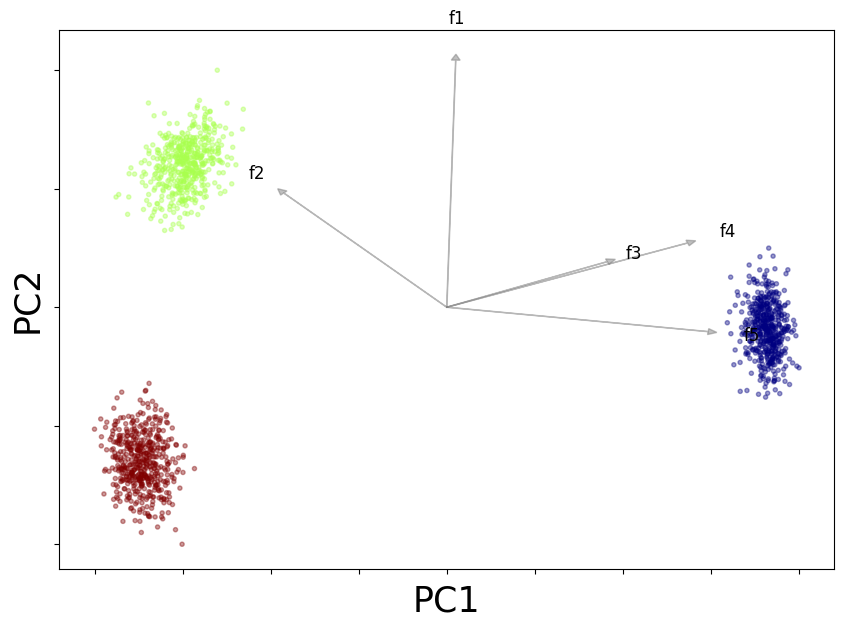

In [15]:
loading,rel_,score = localbiplot.biplot2D(Xdata,plot_=True,labels=ydata,loading_labels=Xdata.columns)


### UMAP-Based Local Biplot


- We propose a method to extend the SVD-based biplot to explore local non-linear data relationships by mapping between linear and non-linear 2D spaces. First, a 2D low-dimensional space $\mathbf{Z}$ is computed using UMAP, followed by sample clustering. Then, local SVD is performed on each cluster, with an affine transformation applied for 2D visualization in the UMAP space. Instead of clustering original features, we cluster the latent feature space into $\tilde{R}$ disjoint sets, where each cluster is represented by its centroid $\boldsymbol{\mu}_r$.

- Then, the well-known K-means clustering algorithm is applied by solving:

\begin{equation}
\tilde{\mathbf{Z}}_r^* = \arg\min_{\boldsymbol{\mu}_r,\mathbf{Z}_r} \sum_{n=1}^N\sum_{r=1}^{\tilde{R}}\|\mathbf{z}_n-\boldsymbol{\mu}_r\|_2^2; \quad \text{s.t.} \quad \tilde{\mathbf{Z}}_r \cap \tilde{\mathbf{Z}}_{r'} = \emptyset, \quad \forall r,r'\in \tilde{R}, \quad r\neq r'.
\end{equation}

- For each cluster, a 2D SVD-based decomposition is performed: $\mathbf{X}_r = \tilde{\mathbf{U}}_r\tilde{\mathbf{S}}_r\tilde{\mathbf{V}}_r^\top$, where $\tilde{\mathbf{U}}_r$ and $\tilde{\mathbf{V}}_r$ represent the top two orthonormal bases, and $\tilde{\mathbf{S}}_r$ contains the singular values. The linear projection is: $\breve{\mathbf{Z}}_r = \mathbf{X}_r \mathbf{B}_r$, with $\mathbf{B}_r = \tilde{\mathbf{V}}_r\tilde{\mathbf{S}}_r^{0.5}$.

- Cluster-based affine transformations align non-linear UMAP embeddings and localized feature bases as: $\tilde{\mathbf{B}}_r = \gamma_r \mathbf{B}_r + \nu_r$, encoding rotation, dilation, and translation.

- Then, we perform a local biplot analysis using UMAP (Uniform Manifold Approximation and Projection).


Dimensionality Reduction...
Affine Transformation...
1/3
plot 1-th group
2/3
plot 2-th group
3/3
plot 3-th group


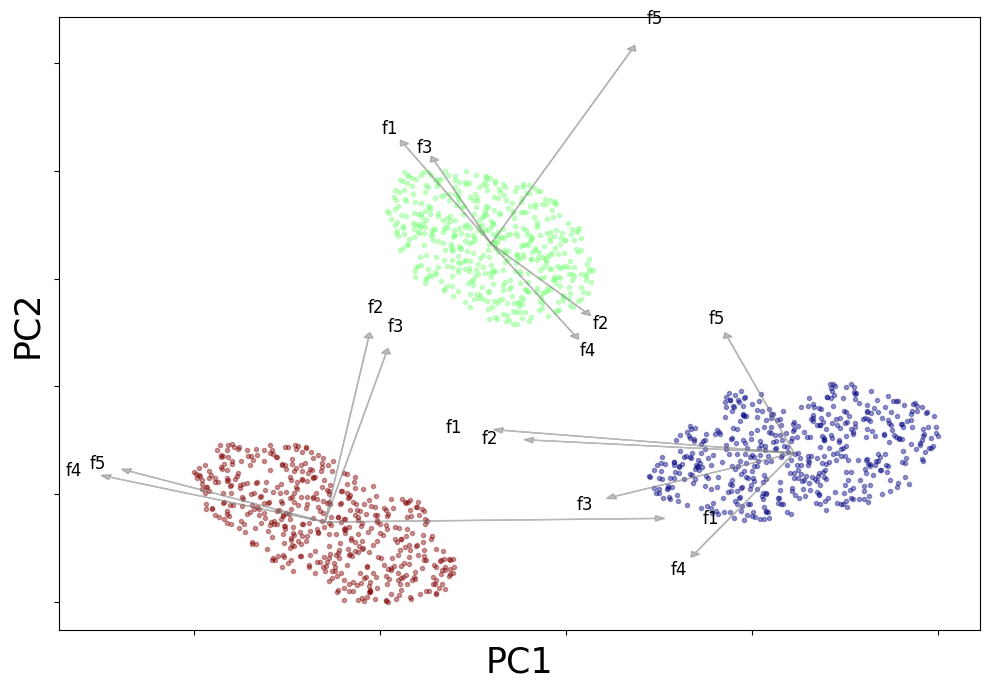

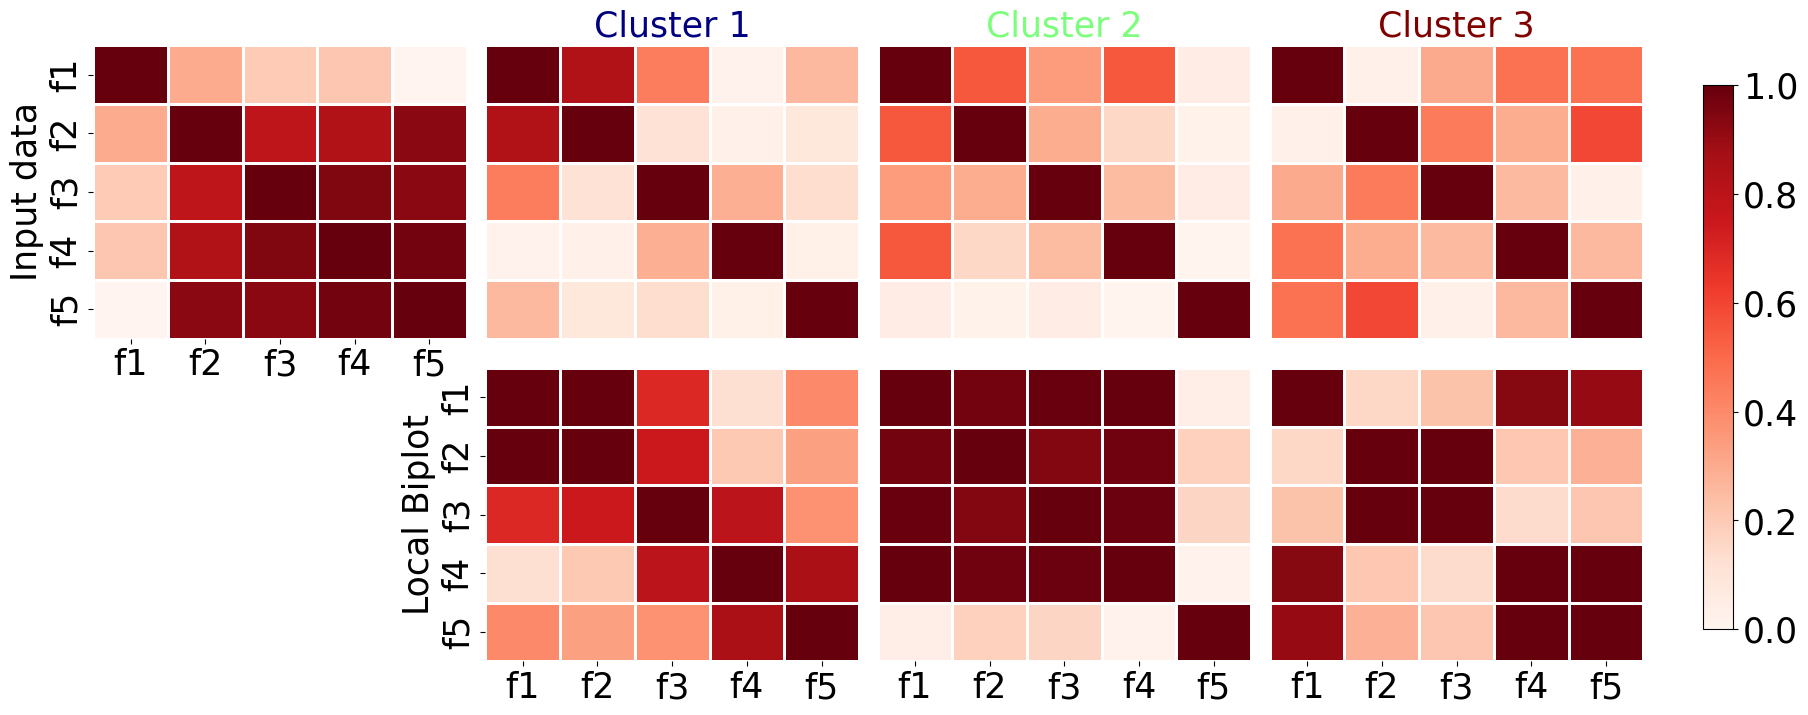

array([0, 0, 0, ..., 2, 2, 2], dtype=int8)

In [16]:
localbiplot.local_biplot2D(Xdata,y=ydata,plot_=True,loading_labels=Xdata.columns,  filename="synth_local_bip")

## **Forage Grasses Dataset**

* This database comprises 35 distinct VIs from five color spaces: RGB, CIE 1976 L*a*b*(CIELab), CIE 1976 L*u*v*(CIELuv), hue-saturation-value (HSV), and hue-saturation-lightness (HSL), for three categories of forage grass:
festuca arundinacea (Fa), diploid Lolium perenne (Lp2n), and tetraploid Lolium perenne (Lp4n).

* From the thermal data, Δ𝑇 and the crop water stress index (CWSI) were calculated.
* A breeder score is provided for three distinct dates designated as T2, T4, and T5. The score ranges from one to nine, based on both biomass quantity and the verdant hue of the plant.
* $𝑃=37$  features and $𝑁=3174$  samples are obtained.



### Download Grass Database

In [17]:
# Repository details
repo_url = "https://github.com/Jectrianama/Datasets_biplot.git"
repo_name = "Datasets_biplot"

# Check if the repository directory already exists
if not os.path.exists(repo_name):
    # Clone the repository if it doesn't exist (suppress verbose output)
    !git clone -l -s $repo_url > /dev/null 2>&1

# Unzip the dataset (suppress verbose output)
!unzip -o /content/Datasets_biplot/PhenotypingData.zip > /dev/null 2>&1

# Path to the CSV file
csv_path = '/content/PhenotypingData.csv'

# Read the CSV file into a DataFrame
data = pd.read_csv(csv_path, sep=';')


### Preprocessing Grass Database

- Rename some dataframe columns from dutch to enlgish




In [18]:
data.rename(columns={'FamKloon':'Famclone', 'Soort': 'Variety', 'GR_Rat':'G/R', 'Hue_val': 'H',
       'S_val' : 'S', 'V_val' : 'V', 'L_val' : 'L', 'a_val' : 'a*', 'b_val':'b*', 'I_val':'I' ,
       'G_R': 'G-R', 'G_B' : 'G-B', 'u_val': 'u*', 'v_val': 'v*'}, inplace=True)
data.drop(columns= ['Famclone', 'Code'	], inplace=True)#

Mapping and replacing values in a DataFrame to replace values in the `'Date'` column of the `data` DataFrame for `'TF1'`, `'TF2'` and `'TF3'`  directly in the original DataFrame, without needing to create a copy.


In [19]:
mapping = {

    130716: 'TF1',
    130828: 'TF2',
    130906: 'TF3'
}

data['Date'].replace(mapping, inplace=True)

replacing varieties 'Fa', 'Lp2n', 'Lp4n' for 1, 2, 3 in Variety columns of the dataset

In [20]:
data['Variety'].replace(['Fa', 'Lp2n', 'Lp4n'],
                        [1, 2, 3], inplace=True)
data = data.dropna().reset_index(drop=True)
data.loc[:,'CWSI'] += 0.0005 #esta columna tiene datos en ceros

Reorganizing the features by color space


In [21]:
data = data[['Date', 'Variety', 'Rkap',  'R', 'G', 'B', 'RCC', 'GCC', 'BCC','ExG', 'ExG2', 'ExR','ExGR', 'GRVI', 'GBVI', 'BRVI', 'G/R', 'G-R', 'G-B', 'VDVI', 'VARI', 'MGRVI', 'CIVE', 'VEG','WI', 'H', 'S', 'V', 'I',  'L', 'a*', 'b*', 'ab', 'NDLab', 'u*', 'v*','uv', 'NDLuv','dT', 'CWSI','Score']]

Creating some copies

In [22]:
date= data['Date']
Xdata = data.iloc[:, 3:41].copy()
ydata = data['Score']


### Instantiating the Local Biplot Class

We instantiate the `LocalBiplot` class, which will be used to perform both global and local biplot analyses. The class is configured with an affine transformation (rotation) and UMAP as the dimensionality reduction method.


In [23]:
localbiplot = lb.LocalBiplot(affine_='rotation',redm='umap')

In [24]:
#loading,rel_,score = localbiplot.biplot2D(Xdata,plot_=True,labels=ydata,loading_labels=Xdata.columns, filename="grass_classic_bip")

### UMAP-Based Local Biplot



- The `local_biplot2D` method includes an optional parameter `corrplot_`, which is set to `True` by default. When enabled, it displays a correlation plot between all features, providing insight into how features are related to each other in the biplot. In this case, we have explicitly set `corrplot=False` to avoid displaying the correlation plot.  


Dimensionality Reduction...
Performing clustering...
(3174,) - [0 1 2 3]
Affine Transformation...
1/4
plot 1-th group
2/4
plot 2-th group
3/4
plot 3-th group
4/4
plot 4-th group


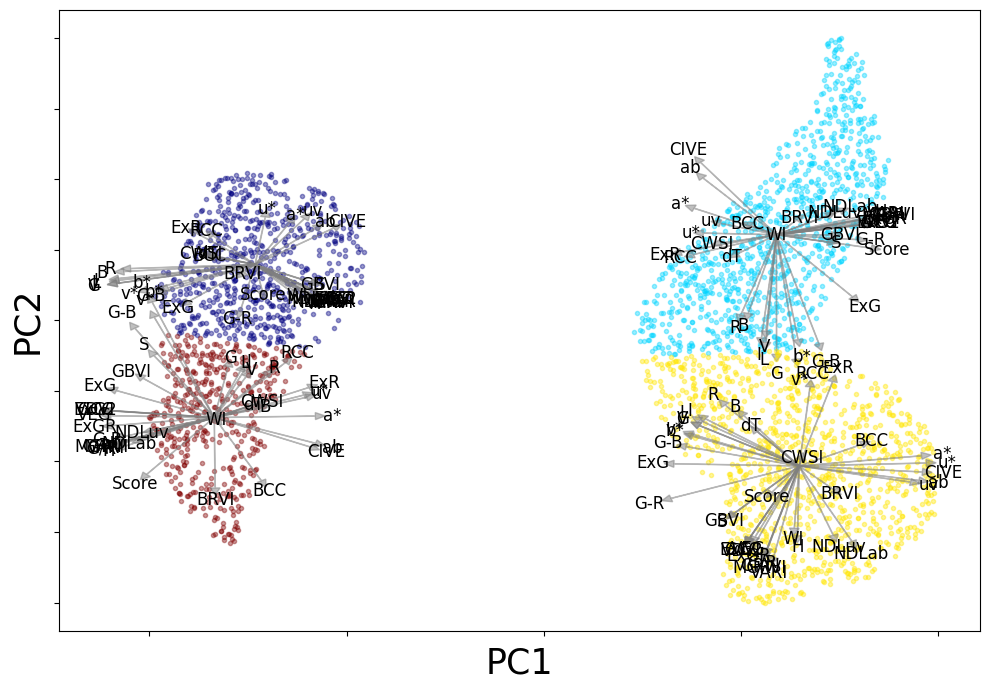

In [25]:
group = localbiplot.local_biplot2D(Xdata,y=4,plot_=True, corrplot_=False, loading_labels=Xdata.columns, filename="grass_local_bip")

### Local Biplot Normalized Feature Relevance

In [26]:
localbiplot.rel_l.shape
max_val = np.max(localbiplot.rel_l)
rel_ = localbiplot.rel_l/max_val
relev = pd.DataFrame(rel_.T, index=Xdata.columns)

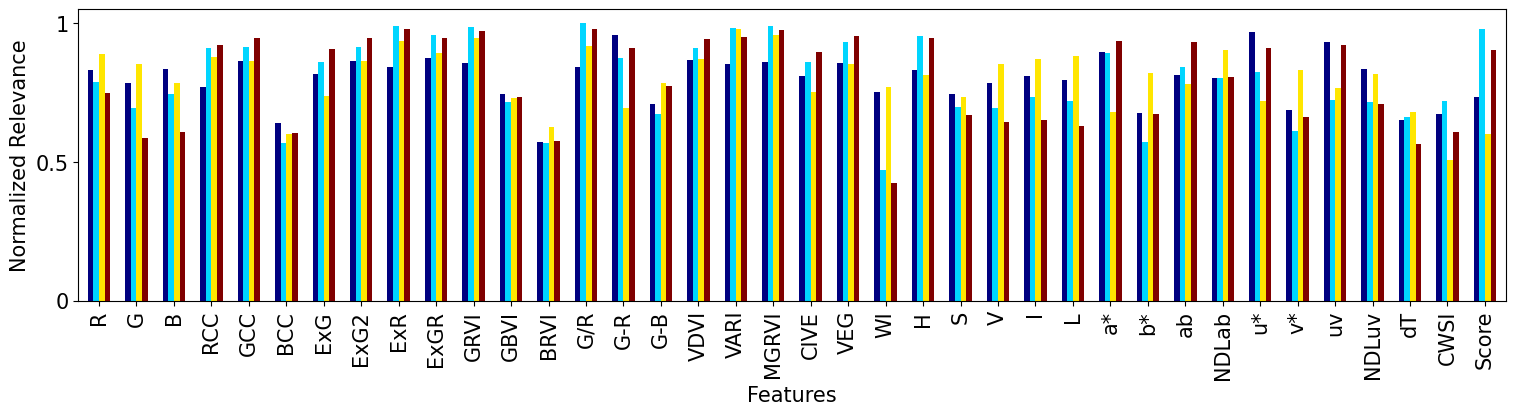

In [27]:
C_ = len(np.unique(group))
cmap_ = mpl.colormaps['jet'].resampled(4)
cmap_ = cmap_(range(4))

ax = relev.plot.bar(rot=90, figsize=(15,4), color=cmap_, fontsize = 15, legend=False,width=0.6)
ax.set_yticks([0, 0.5, 1], ['0', '0.5', '1'])
#ax.tick_params(labelbottom=False)
#ax.set_xticks([])
#ax.set_yticks([])
#ax.spines['top'].set_visible(False)
#ax.spines['right'].set_visible(False)
ax.get_figure().tight_layout()
ax.set_xlabel('Features', fontsize=15)
ax.set_ylabel('Normalized Relevance', fontsize=15)

#ax.legend(loc='upper right', bbox_to_anchor=(1.4, 1), frameon=False)
# Save figure
ax.get_figure().savefig('plot.pdf', dpi=300)


### SVD-based Biplot Analysis using PCA


- The SVD-based biplot is generated using PCA (Principal Component Analysis). It projects the data into a 2D plane, showing relationships between features and the clusters in the dataset.

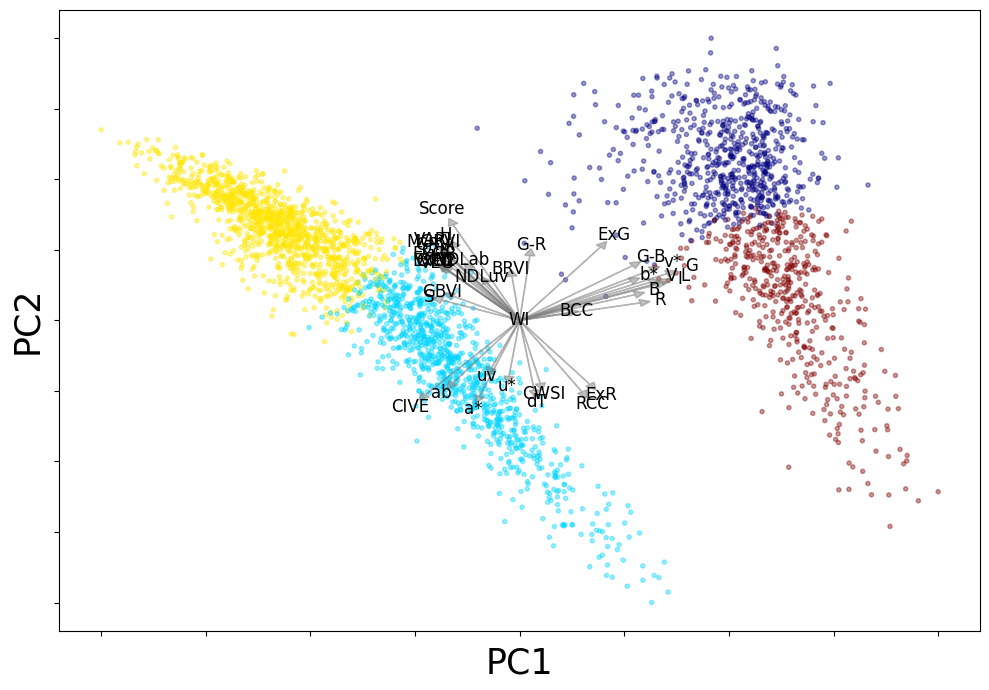

In [28]:
loading,rel_,score = localbiplot.biplot2D(Xdata,plot_=True,labels=group,loading_labels=Xdata.columns, filename="grass_classic_bip")

### SVD-based Biplot Normalized Feature Relevance


In [29]:
max_val = np.max(rel_)
rel_ = rel_/max_val
relev = pd.DataFrame(rel_.T, index=Xdata.columns)

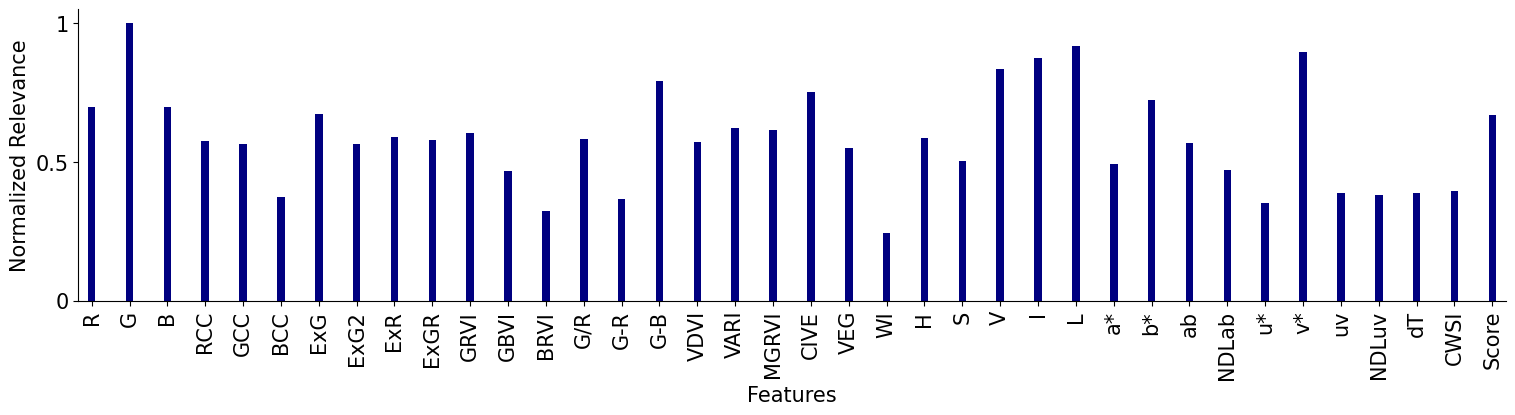

In [30]:
C_ = len(np.unique(group))
cmap_ = mpl.colormaps['jet'].resampled(4)
cmap_ = cmap_(range(4))
ax = relev.plot.bar(rot=90, figsize=(15,4), color=cmap_, fontsize = 15, legend=False, width=0.2)
ax.set_yticks([0, 0.5, 1], ['0', '0.5', '1'])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_figure().tight_layout()
ax.set_xlabel('Features', fontsize=15)
ax.set_ylabel('Normalized Relevance', fontsize=15)

#ax.legend(loc='upper right', bbox_to_anchor=(1.4, 1), frameon=False)
# Save figure
ax.get_figure().savefig('PCA_importances_ALL.pdf', dpi=300)

 ### KDE Estimation

 The 2D projection using the breeding score as color to provide further insights is given, while the flight dates (TF1, TF2, and TF3) determine the color of the curves.  The principal components in the projections have been scaled to a range between -1 and 1 for easier interpretation and visual comparison.



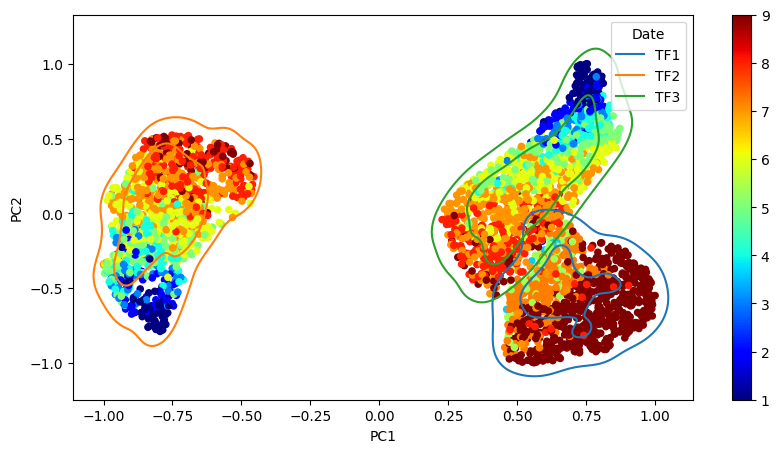

In [31]:
localbiplot.kdeplot_(data, hue_attr='Date', c_attr ='Score')

### Forage Grasses Pearson Correlation Results

- we compute the Pearson correlation ${\varrho_{pp'}}\in[-1,1]$ between features as follows:
\begin{equation}
\varrho_{pp'} = \frac{\langle\boldsymbol{\xi}_p - \bar{\xi}_p \mathbf{1},\boldsymbol{\xi}_{p'} - \bar{\xi}_{p'}\mathbf{1}\rangle_2}{\|\boldsymbol{\xi}_p - \bar{\xi}_p \mathbf{1}\|_2\|\boldsymbol{\xi}_{p'} - \bar{\xi}_{p'} \mathbf{1}\|_2},
\end{equation}

where $\boldsymbol{\xi}_p\in ℜ^N $ holds the $p$-th column in $\mathbf{X}$, $\bar{\xi}_p=\tfrac{1}{N}\sum_{n=1}^N \xi_{pn},$ and $p,p'\in P.$


- A Local Biplot-based feature correlation $\tilde{\varrho}_{pp'}\in[-1,1]$ is computed for a given matched basis matrix by replacing $\boldsymbol{\xi}_p$ as the $p$-th row $\tilde{\mathbf{b}}\in ℜ^2$ of $\tilde{\mathbf{B}}$ in the equation above.

- We show the absolute correlation between the VIs and the breeding score (target) for each species individually and collectively. We also establish correlations for each cluster separately and throughout the dataset.


Performing clustering...
(3174,) - [0 1 2 3]
Affine Transformation...
1/4
2/4
3/4
4/4


<Figure size 640x480 with 0 Axes>

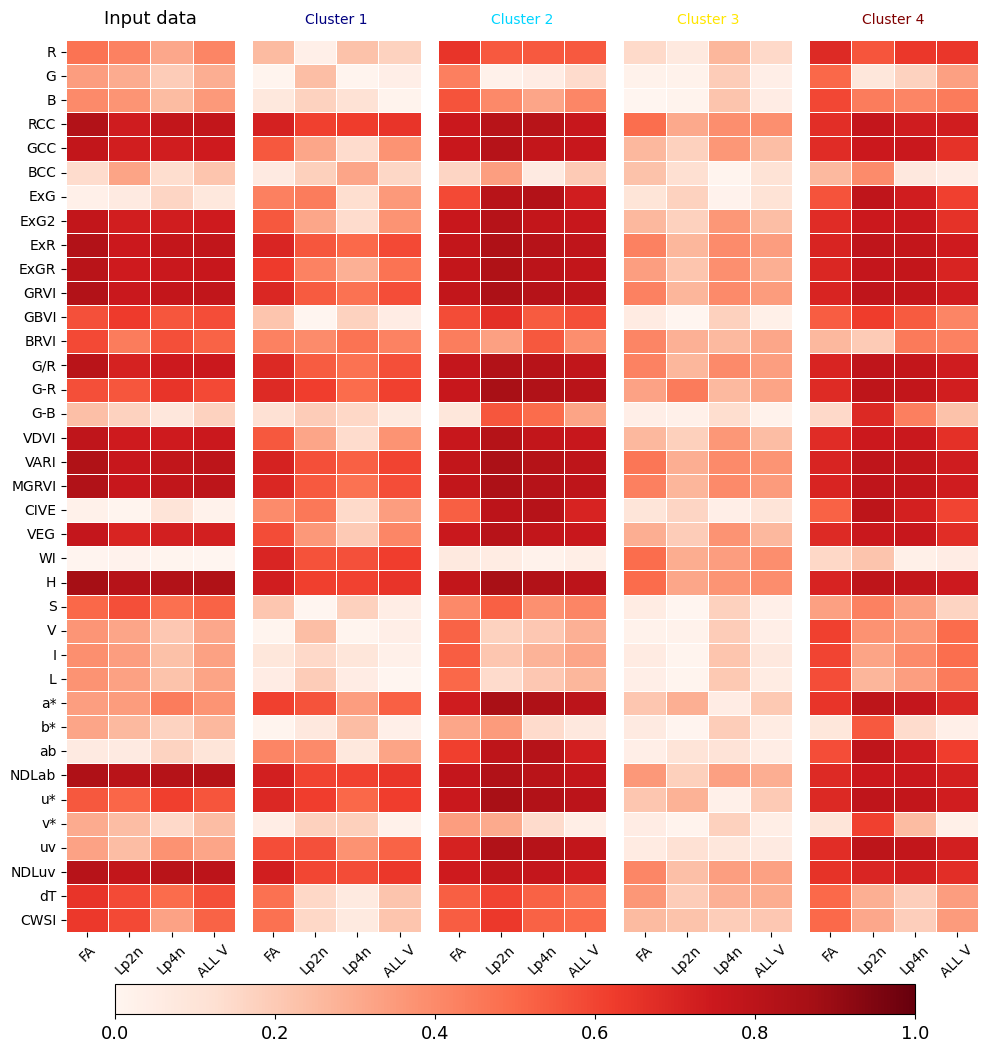

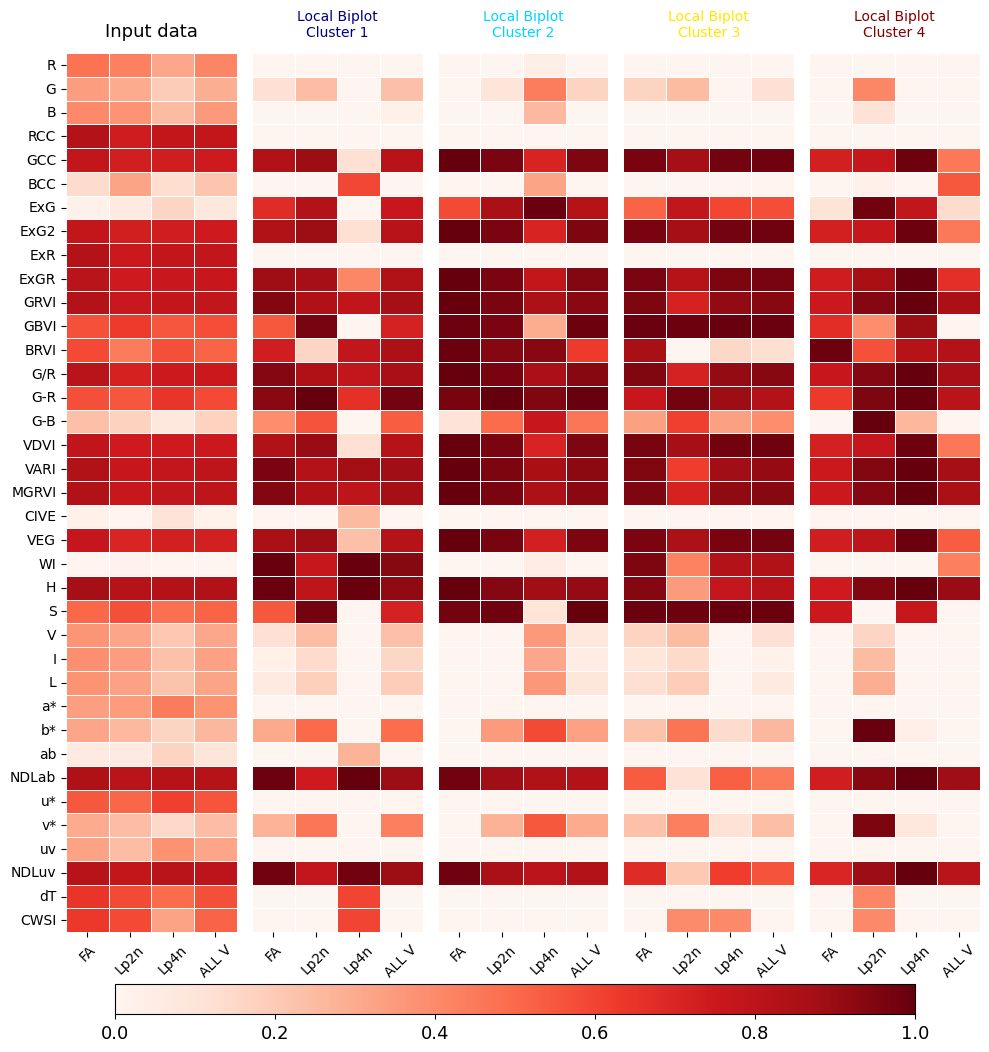

In [32]:
localbiplot.correlations_by_target(data=data,X=Xdata,y=4,loading_labels=Xdata.columns, filename='grass', key='Variety')